In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import h5py
import json 
import sys 
from scipy.io import FortranFile
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
sys.path.append("/home/sferrone/GC-tidal-loss/experiments/functions/")
import inputMW
import inputGC
import global_functions as GF
from mpl_toolkits import mplot3d
import numba
import orbitCoords as OC
import trace_orbit as TO 
import pandas as pd

In [2]:
k=0
GCnames,version,model=np.loadtxt("clean_stream.txt",delimiter=',',dtype=str,unpack=True)
f=open("config.json")
C = json.load(f)
dt=0.3
backwardpath,forwardpath=TO.orbitpath(C)
streampath=TO.get_streampath(version=version[k],model=model[k])
yprimes=pd.read_csv("gc_yprimes.csv",sep=",")
plt.style.use('dark_background')

EDR3 PII


In [3]:
# just do for each GC
omegas,omegaNorm=[],[]
for k in range(len(GCnames)):
    COM=OC.getCOM(GCnames[k])
    rvec=[COM.x.value,COM.y.value,COM.z.value]
    vvec=[COM.v_x.value,COM.v_y.value,COM.v_z.value]
    omega=np.cross(rvec,vvec)/np.linalg.norm(rvec)**2
    omegas.append(omega)
    omegaNorm.append(np.linalg.norm(omega))

In [4]:
topBottom=np.random.rand(len(GCnames))
condB=topBottom<0.5
condT=topBottom>0.5
topBottom[condB]=1
topBottom[condT]=0
cmap = plt.cm.get_cmap("hsv")
omegaNorm=np.array(omegaNorm)
GCnames=np.array(GCnames)
mycolors=[]
sampling=np.linspace(0,1,len(GCnames))
for i in range(len(GCnames)):
    mycolors.append(cmap(sampling[i]))

Text(0.5, 0, '$\\omega$ (km s$^{-1}$ kpc$^{-1}$)')

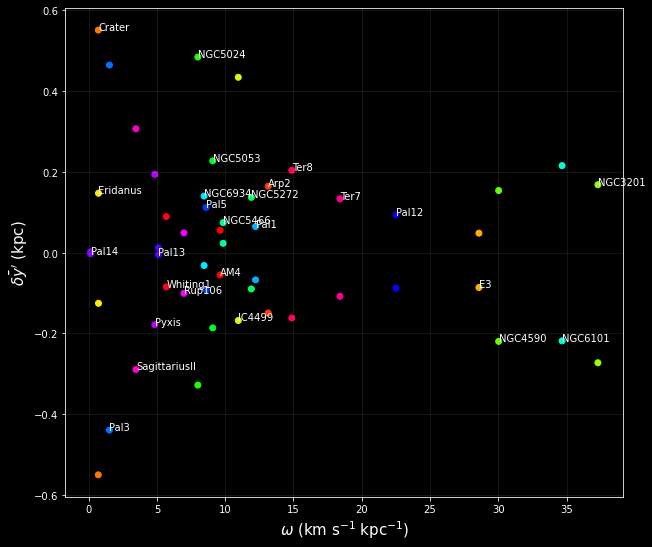

In [5]:
fig,ax=plt.subplots(figsize=(10,9))
ax.scatter(omegaNorm,yprimes['trailing'],c=mycolors)
ax.scatter(omegaNorm,yprimes['leading'],c=mycolors)
ax.grid(True,alpha=0.1)
for k in range(len(GCnames)):
    if topBottom[k]:
        ax.text(omegaNorm[k],yprimes['leading'][k],GCnames[k])
    else:
        ax.text(omegaNorm[k],yprimes['trailing'][k],GCnames[k])

ax.set_ylabel(r"$\bar{\delta y'}$ (kpc)",size=15);
ax.set_xlabel(r"$\omega$ (km s$^{-1}$ kpc$^{-1}$)",size=15);

# get $d\omega/dt$

$\dot{\omega} = \frac{\vec{v}\times \vec{v}}{|r^2|} + \frac{\vec{r}\times \vec{\dot{v}}}{|r^2|} - 2\frac{|v|}{|r^3|}\vec{r}\times \vec{v}$


So i need the acceleration vector at each point... but isnt the acceleration just due to gravity? Therefore parallel to $\vec{r}$

In [6]:
from scipy.interpolate import CubicSpline
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
cond = np.abs(t) < dt
ts,Ws = t[cond],W[cond,:]
past,future=(ts < 0),(ts > 0)
x,y,z = Ws[:,0],Ws[:,1],Ws[:,2]
vx,vy,vz = Ws[:,3],Ws[:,4],Ws[:,5]

In [16]:
csx,csy,csz=CubicSpline(ts,vx),CubicSpline(ts,vy),CubicSpline(ts,vz)
ax,ay,az=csx(ts,1),csy(ts,1),csz(ts,1)
csx,csy,csz=CubicSpline(ts,x),CubicSpline(ts,y),CubicSpline(ts,z)
axx,ayy,azz=csx(ts,2),csy(ts,2),csz(ts,2)
vvx,vvy,vvz=csx(ts,1),csy(ts,1),csz(ts,1)

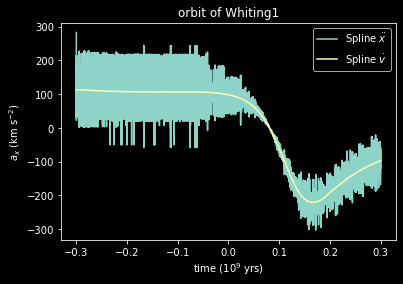

In [9]:
convert=vx.max()/vvx.max()

fig,axis=plt.subplots()
axis.plot(ts,convert*axx,label=r"Spline $\ddot{x}$")
axis.plot(ts,ax,label=r"Spline $\dot{v}$")
axis.set_xlabel("time (10$^9$ yrs)")
axis.set_ylabel("$a_x$ (km s$^{-2}$)")
axis.legend()
axis.set_title("orbit of {:s}".format(GCnames[k]));


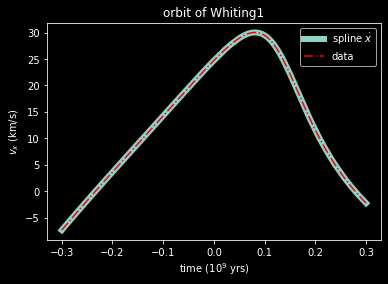

In [10]:
convert=vx.max()/vvx.max()
plt.plot(ts,convert*vvx,linewidth=6,label=r"spline $\dot{x}$")
plt.plot(ts,vx, '-.',c='r',label="data")
plt.xlabel("time (10$^9$ yrs)")
plt.ylabel("$v_x$ (km/s)")
plt.title("orbit of {:s}".format(GCnames[k]))
plt.legend()

Now try to look at $\dot{\omega}$ for one GC and its delta Y at a time

$ \vec{\omega} = \frac{\vec{r}\times \vec{v}}{r^2} $


In [31]:
vel=np.zeros((vx.shape[0],3))
pos=np.zeros((vx.shape[0],3))
odot=np.zeros((vx.shape[0],3))
pos[:,0],pos[:,1],pos[:,2] = x,y,z
vel[:,0],vel[:,1],vel[:,2] = vx,vy,vz
omega=np.cross(pos,vel,axis=1)/(np.linalg.norm(pos)**2)
omegamag=np.linalg.norm(omega,axis=1)
odotx,odoty,odotz=CubicSpline(ts,omega[:,0]),CubicSpline(ts,omega[:,1]),CubicSpline(ts,omega[:,2])
odotmag=CubicSpline(ts,omegamag)
odotMAG=odotmag(ts,1)
odot[:,0],odot[:,1],odot[:,2]=odotx(ts,1),odoty(ts,1),odotz(ts,1)

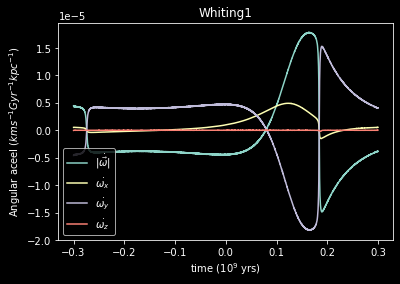

In [45]:
plt.plot(ts,odotMAG,label=r"$\dot{|\vec{\omega}|}$")
plt.plot(ts,odot[:,0],label=r"$\dot{\omega_x}$")
plt.plot(ts,odot[:,1],label=r"$\dot{\omega_y}$")
plt.plot(ts,odot[:,2],label=r"$\dot{\omega_z}$")
plt.legend();
plt.xlabel(r"time $(10^9$ yrs)");
plt.ylabel(r"Angular aceel ($km s^{-1} Gyr^{-1} kpc^{-1}$)");
plt.title(GCnames[k]);

# do $\delta y' , \dot{\omega}$

In [46]:
stream=h5py.File(streampath+GCnames[k]+".h5")
COM = OC.getCOM(GCnames[k])
mass,radius=inputGC.Plummer(GCnames[k]) 
# load ORBIT
t,W=TO.load_orbit(backwardpath,forwardpath,GCnames[k],C)
cond = np.abs(t) < dt
ts,Ws = t[cond],W[cond,:]
past,future=(ts < 0),(ts > 0)
x,y,z = Ws[:,0],Ws[:,1],Ws[:,2]
vx,vy,vz = Ws[:,3],Ws[:,4],Ws[:,5]
# initialize 
Xp,Yp,Zp=np.array(stream['galactocentric']['X']),np.array(stream['galactocentric']['Y']),np.array(stream['galactocentric']['Z'])
VXp,VYp,VZp=np.array(stream['galactocentric']['VX']),np.array(stream['galactocentric']['VY']),np.array(stream['galactocentric']['VZ'])
xprime,star_coords,indexes,tt=np.zeros(Xp.shape),np.zeros((Xp.shape[0],3)),np.zeros(Xp.shape),np.zeros(Xp.shape)
xprimeORB=np.zeros(x.shape)
xcom,ycom,zcom=COM.x.value,COM.y.value,COM.z.value
xprimeORB=np.zeros(x.shape)
tt=np.zeros(Xp.shape)
xprimeORB=OC.define_orbital_coordinate(x, y, z, xcom, ycom, zcom, xprimeORB)
tt, xprime, star_coords, indexes = OC.getorbcoords(Xp, Yp, Zp, ts, x, y, z, vx, vy, vz, xprimeORB, tt, xprime, star_coords, indexes)
cond0 = stream['energy']['Tescape'][:]>0
cond1 = xprime < 0
cond2 = xprime > 0
cond1 = np.logical_and(cond0,cond1)
cond2 = np.logical_and(cond0,cond2)

Text(0.5, 1.0, 'Whiting1')

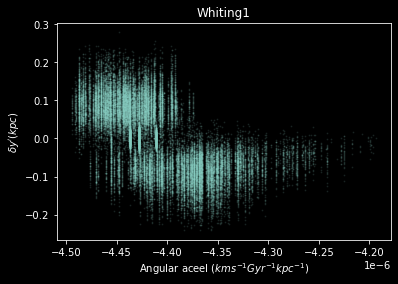

In [81]:
odotPerStar=odotmag(tt,1)
plt.scatter(odotPerStar,star_coords[:,0], alpha=0.1,s=1)
plt.ylabel(r"$\delta y' (kpc)$");
plt.xlabel(r"Angular aceel ($km s^{-1} Gyr^{-1} kpc^{-1}$)");
plt.title(GCnames[k])

I don't think there's much interesting information here. We see that the leading tail (at negative $\delta y'$) has a greater range in angular acceleration. However there isn't much predictability between the two. The greater than for the trailing tail is only becuase this part of the stream must be closer to approaching a peri-center passage

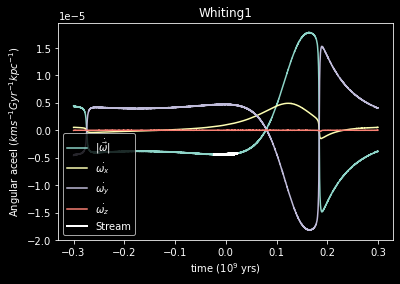

In [82]:
plt.plot(ts,odotMAG,label=r"$\dot{|\vec{\omega}|}$")
plt.plot(ts,odot[:,0],label=r"$\dot{\omega_x}$")
plt.plot(ts,odot[:,1],label=r"$\dot{\omega_y}$")
plt.plot(ts,odot[:,2],label=r"$\dot{\omega_z}$")
plt.plot(tt,odotPerStar, c='w',linewidth=2, label='Stream')
plt.legend();
plt.xlabel(r"time $(10^9$ yrs)");
plt.ylabel(r"Angular aceel ($km s^{-1} Gyr^{-1} kpc^{-1}$)");
plt.title(GCnames[k]);

yes. and here we are generally slowing down... and the rate at which we are slowing down in slowing down...

What about the stream versus omega?


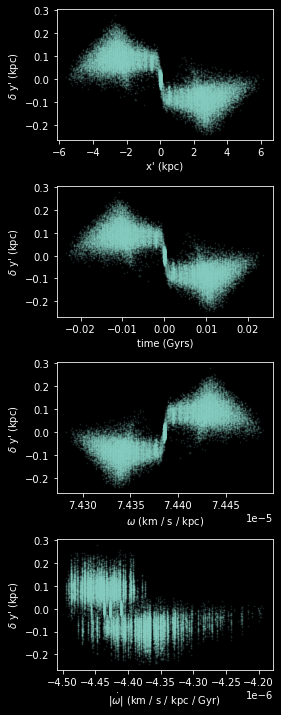

In [93]:
omegaATPARTICLE=odotmag(tt,0)
fig,ax=plt.subplots(4,1,figsize=(4,10))
# plt.scatter(omegaATPARTICLE,star_coords[:,0],s=1,alpha=0.1)
ax[0].scatter(xprime,star_coords[:,0],s=1,alpha=0.1)
ax[1].scatter(tt,star_coords[:,0],s=1,alpha=0.1)
ax[2].scatter(omegaATPARTICLE,star_coords[:,0],s=1,alpha=0.1)
ax[3].scatter(odotPerStar,star_coords[:,0],s=1,alpha=0.1)
ax[0].set_xlabel("x' (kpc)")
ax[1].set_xlabel("time (Gyrs)")
ax[2].set_xlabel("$\omega$ (km / s / kpc)")
ax[3].set_xlabel("$\dot{|\omega|}$ (km / s / kpc / Gyr)")
for xxx in ax:
    xxx.set_ylabel(r"$\delta$ y' (kpc)")

fig.tight_layout()

# Escape time
Let us look at $\omega$ and $\dot{\omega}$ at release time

In [135]:
cond=stream['energy']['Tescape'][:] > 0
tesc=stream['energy']['Tescape'][cond]/10 - 5 
x,y,z = W[:,0],W[:,1],W[:,2]
vx,vy,vz = W[:,3],W[:,4],W[:,5]

vel=np.zeros((vx.shape[0],3))
pos=np.zeros((vx.shape[0],3))
odot=np.zeros((vx.shape[0],3))
pos[:,0],pos[:,1],pos[:,2] = x,y,z
vel[:,0],vel[:,1],vel[:,2] = vx,vy,vz

omega=np.cross(pos,vel,axis=1)/(np.linalg.norm(pos)**2)
omegamag=np.linalg.norm(omega,axis=1)
oxspline,oyspline,ozspline=CubicSpline(t,omega[:,0]),CubicSpline(t,omega[:,1]),CubicSpline(t,omega[:,2])
ospline=CubicSpline(t,omegamag)
omegaMAG=ospline(tesc,0)
odotMAG=ospline(tesc,1)


Text(0, 0.5, 'Counts')

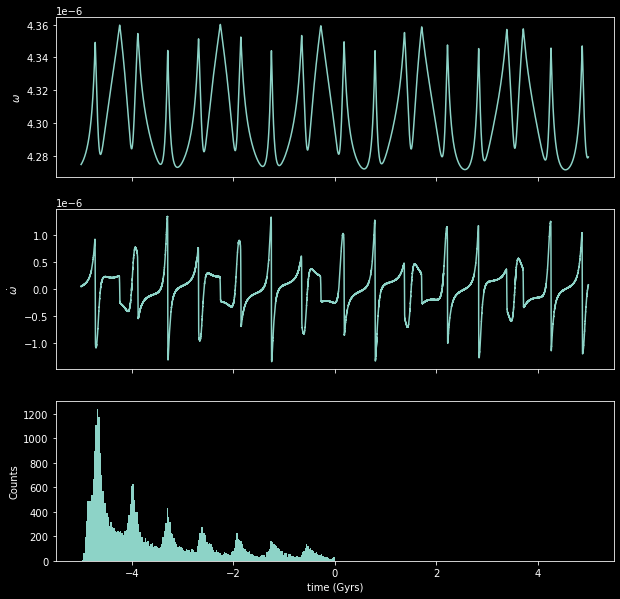

In [213]:
nbins=int(np.ceil(np.sqrt(tesc.shape[0])))
fig,ax=plt.subplots(3,1,sharex=True,figsize=(10,10))
ax[0].plot(t,ospline(t,0))
ax[1].plot(t,ospline(t,1))
ax[2].hist(tesc,bins=nbins);
ax[2].set_xlabel("time (Gyrs)")
ax[0].set_ylabel("$\omega$")
ax[1].set_ylabel("$\dot{\omega}$")
ax[2].set_ylabel("Counts")

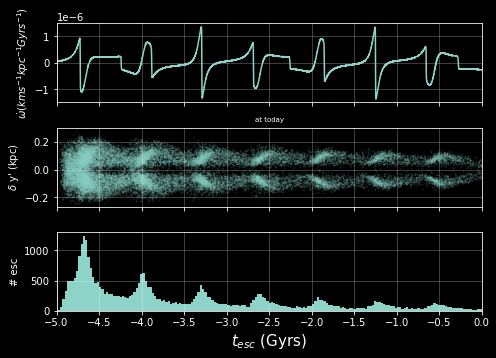

In [243]:
fig,ax=plt.subplots(3,1,figsize=(7,5),sharex=True)
# ax[0].scatter(ospline(tesc,0),star_coords[cond,0], s=1,alpha=0.1)
# ax[1].scatter(ospline(tesc,1),star_coords[cond,0], s=1,alpha=0.1)
ax[1].scatter(tesc,star_coords[cond,0], s=1,alpha=0.1)
ax[0].plot(t,ospline(t,1))
ax[0].set_ylabel(r"$\dot{\omega} (km s^{-1}kpc^{-1}Gyrs^{-1})$")

ax[2].set_xlabel(r"$t_{esc}$ (Gyrs)",size=15);
ax[2].hist(tesc,bins=nbins);

ax[0].set_xticks(np.linspace(-5,0,11));
ax[1].set_xticks(ax[0].get_xticks());
ax[2].set_xticks(ax[0].get_xticks());

ax[1].set_ylabel(r"$\delta$ y' (kpc)");
ax[1].set_title("at today",size=7)

ax[2].set_ylabel("# esc")
for xxx in ax:
    xxx.grid(True,alpha=0.3)
    xxx.set_xlim(-5,0)

fig.tight_layout()

In regards to the plot above, I don't think this contains the secrete answer. to having a simple stream to-orbit correction. What i've learned is that in our model, we lose stars continuously. We have peaks in places where $\dot{\omega}$ changes sign. These must per pericenter passages ? (à verifier with a check of R versus $\dot{\omega}$)

One interesting thing that've learned is that we have a stronger particle release at these peri-center passage releases as well as a greater dispersion of distances at which these particles are released. i.e. a larger variance in $\delta y'$

Text(0, 0.5, '$\\dot{\\omega}$')

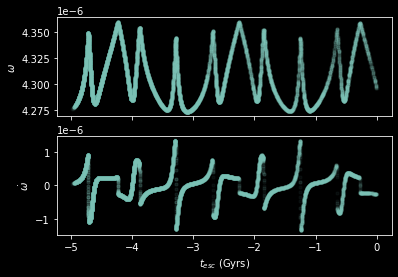

In [172]:
fig,ax=plt.subplots(2,1,sharex=True)
ax[0].scatter(tesc,ospline(tesc,0),alpha=0.05,s=10)
ax[1].scatter(tesc,ospline(tesc,1),alpha=0.05,s=10)
ax[1].set_xlabel(r"$t_{esc}$ (Gyrs)")
ax[0].set_ylabel("$\omega$")
ax[1].set_ylabel("$\dot{\omega}$")

Text(0.5, 1.0, 'Whiting1')

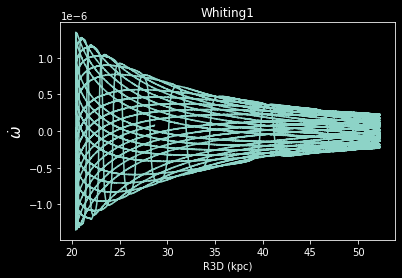

In [188]:
R3D=np.linalg.norm(pos,axis=1)
plt.plot(R3D,ospline(t,1))
plt.xlabel("R3D (kpc)")
plt.ylabel(r"$\dot{\omega}$",size=15)
plt.title(GCnames[k])

I was not expecting it to look this cool. This matches a bit of my expectations, as in the mad o dot happens at the smallest R3D, but this envelope and cyclic behaviour surprised me, though it shouldn't have since this is orbital dynamics

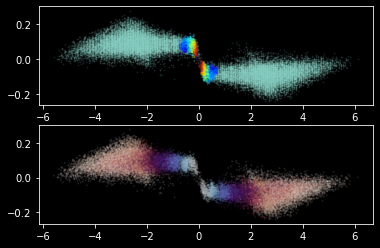

In [252]:
tesc1=stream['energy']['Tescape'][:]/10 - 5
cond1 = tesc1 > -0.7
cond2 = np.logical_and(-1.3<tesc1,tesc1<-0.7)
tesc1F=tesc1[cond1]
tesc1F1=tesc1[cond2]

fig,ax=plt.subplots(2,1)
ax[0].scatter(xprime[cond],star_coords[cond,0],alpha=0.1,s=1)
ax[0].scatter(xprime[cond1],star_coords[cond1,0],alpha=0.2,s=1,c=tesc1F,cmap=plt.cm.get_cmap("jet"))
ax[1].scatter(xprime[cond],star_coords[cond,0],alpha=0.1,s=1,c=tesc,cmap=plt.cm.get_cmap("twilight_r") )
# ax[1].scatter(xprime[cond2],star_coords[cond2,0],alpha=0.2,s=1,c=tesc1F1,cmap=plt.cm.get_cmap("jet"))

In [198]:
tesc1

1535

In [194]:
stream['energy'].keys()

<KeysViewHDF5 ['Tescape', 'phiGC', 'phiMW']>